## Using MELTS and MAGEMin as liquid-only thermometers (finding liquidus temperatures)

Prior to starting any calculations it is necessary to load the relevant packages. As most of the work is done in the pyMELTScalc functions, only a few packages need to be imported into your notebook. These include $numpy$ and $pandas$ (for data processing), $matplotlib.pyplot$ for the visualisation of results, and $pyMELTScalc$ itself. In addition, it is necessary to append the path to the alphaMELTS for MATLAB/Python packages (available via GitLab), which are done using $sys$.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyMELTScalc as M
import Thermobar as pt

import sys
sys.path.append('G:/My Drive/2022/MELTS/MELTS_Matlab-master/package')

To test the ability of MELTS and MAGEMin to act at liquid-only thermometers we need some experiments to test them against. Here, we use a database of experimental data compiled by Wieser and isolate all the melt compositions in the $Liq$ sheet. We then list the elements that must be present for MELTS calculations to be performed.

In [2]:
Data = pd.read_excel('LEPR_Wet_stitched_Sept2022.xlsx', sheet_name = 'Liq')
Data['Fe3Fet_Liq'] = np.zeros(len(Data['SiO2_Liq'])) + 0.15
Data['CO2_Liq'] = np.zeros(len(Data['SiO2_Liq']))
Elements = ['SiO2_Liq', 'TiO2_Liq', 'Al2O3_Liq', 'FeOt_Liq', 'MgO_Liq', 'MnO_Liq', 
            'CaO_Liq', 'Na2O_Liq', 'K2O_Liq', 'P2O5_Liq', 'H2O_Liq', 'CO2_Liq', 'Fe3Fet_Liq']

The entire experimental dataset contains over 2000 samples. Therefore, to reduce the computational time in this example spreadsheet I isolate 400 experiments (randomly selected) to be used in the following calculations. A new DataFrame is constructed using only these experiments.

In [3]:
Ch = np.random.choice(range(len(Data['SiO2_Liq'])), 2000, replace=False)
Test = Data.copy()
Test = Test.loc[Ch]
Test = Test.reset_index(drop = True)

Now we have our dataset to be investigated we can run the liquidus calculations. As a standard, I run these with 20 calculations run in parallel ($'cores'$), but you may need to reduce this number for computers with less RAM or lower spec processors.

The calculation here specifies that we wish to use the MELTS thermodynamic models, provides a DataFrame of compositions, and the conditions of the calculation. The pressure is taken from the pressure of each experiment and the initial temperature for the calculation (the starting point for the findLiq function) is set at the experimental temperature in K. By setting the initial temperature to the experimental temperature in K, but searching for the liquidus in Celcius, we ensure that most calculations will start above the liquidus, which reduces the possibility that the calculations will hit a failure prior to the liquidus being found.

In [ ]:
%timeit T_liq, H2O = M.findLiq_multi(Model = "MELTSv1.2.0", comp = Test[Elements], T_initial_C = Test['T_K'].values-200, P_bar = Test['P_kbar'].values*1000)

  0%|          | 0/100 [00:00<?, ?it/s]

In [10]:
%timeit T_Liq = pt.calculate_liq_only_temp(liq_comps=Test, equationT="T_Put2008_eq22_BeattDMg", P = Test['P_kbar'].values)-273.15

15 ms ± 184 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Now that we have the results of this analysis, we can compare the results of these calculations to the true experimental temperature. Experiments that have no reported water typically show a very poor match to the experimental temperature, and are thus excluded from the following comparison. Additionally, we exlude any calculations that did not return a result (T_liq = 0).

Overall, MELTS does an acceptable job in reproducing the experimental temperatures, although it is notable that the liquidus temperature is typically overpredicted by around 50 $^{o}$C.

Text(0, 0.5, 'Experimental Temperature ($^{o}$C)')

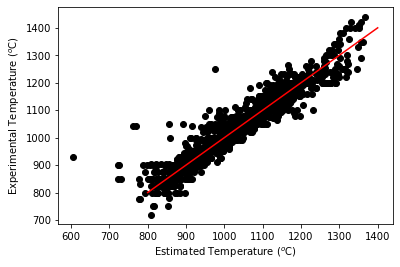

In [12]:
f, a = plt.subplots(1,1)
a.plot(T_Liq[(Test['H2O_Liq'] > 0) & (T_liq > 0)], Test['T_K'][(Test['H2O_Liq'] > 0) & (T_liq > 0)]-273.15, 'ok')
a.plot([800,1400],[800,1400], 'r-')
a.set_xlabel('Estimated Temperature ($^{o}$C)')
a.set_ylabel('Experimental Temperature ($^{o}$C)')

To perform calculations in MAGEMin, a column for Cr2O3 is required in the input dataset and a new list of Elements must be specified.

In [6]:
Test['Cr2O3_Liq'] = np.zeros(len(Test['SiO2_Liq']))
Elements = ['SiO2_Liq', 'Al2O3_Liq', 'CaO_Liq', 'MgO_Liq', 'FeOt_Liq', 'K2O_Liq', 'Na2O_Liq', 'TiO2_Liq', 'Cr2O3_Liq', 'H2O_Liq', 'Fe3Fet_Liq']


Now the new elements list has been described, we can repeat the calculations performed above in MAGEMin. For these calculations we run 10 simulations in parallel and specify the MAGEMin calculations by stating $Model = "Holland"$.

In [7]:
T_liq, H2O = M.findLiq_multi(Model = "Holland", comp = Test[Elements], T_initial_C = Test['T_K'].values-273.15, 
                             P_bar = Test['P_kbar'].values*1000)

  0%|          | 0/20 [00:00<?, ?it/s]

Plotting up the results, we can see that below 1100 $^{o}$C the fit between the experimental and predicted temperatures are quite poor. Above 1100 $^{o}$C, however, these is a good agreement between these experiments and predictions. 

Text(0, 0.5, 'Experimental Temperature ($^{o}$C)')

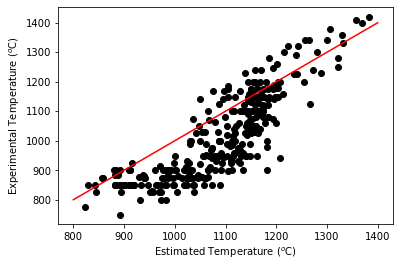

In [8]:
f, a = plt.subplots(1,1)
a.plot(T_liq[(Test['H2O_Liq'] > 0) & (T_liq > 0)], Test['T_K'][(Test['H2O_Liq'] > 0) & (T_liq > 0)]-273.15, 'ok')
a.plot([800,1400],[800,1400], 'r-')
a.set_xlabel('Estimated Temperature ($^{o}$C)')
a.set_ylabel('Experimental Temperature ($^{o}$C)')